# Exploratory Analysis

This notebook contains all steps and decisions in the exploratory analysis phase of the pipeline.

---

## The Required Imports

Below are all the modules needed to run the code cells in this notebook.

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from wrangle import wrangle_kepler_explore
from acquire_kepler import AcquireKeplerData

from preprocessing import *
from univariate_analysis import *
from bivariate_analysis import *

---

## Acquire and Prepare the Data

Let's use the wrangle_kepler function to get the data.

In [26]:
# Create an acquire object in case we need it later.
acquire = AcquireKeplerData('kepler.csv')

kepler = wrangle_kepler_explore()
kepler.shape

(6031, 44)

---

## Split the Data

The plan is to build some machine learning models after exploration so let's split our data now to prevent data leakage.

In [3]:
# We'll split into three sets, the training set and two unseen data sets. This is a classification problem
# so we'll stratify on the disposition column.
train, validate, test = split_data(kepler, stratify = 'disposition')

In [4]:
train.shape, validate.shape, test.shape

((3376, 44), (1448, 44), (1207, 44))

---

## Explore

Now let's begin exploring the data. We'll only explore the train set and leave the other two alone.

### Univariate Analysis

#### Analyzing the Target

Let's see how the target is distributed.

In [5]:
train.disposition.value_counts()

FALSE POSITIVE    2107
CONFIRMED         1269
Name: disposition, dtype: int64

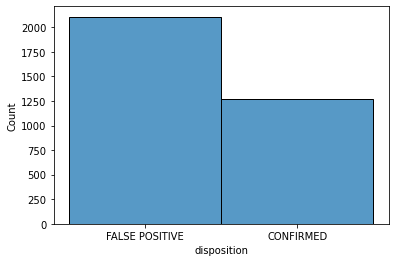

In [6]:
sns.histplot(data = train, x = 'disposition');

In [7]:
2107 / 3376

0.6241113744075829

In [8]:
1269 / 3376

0.37588862559241704

##### Takeaway

We mostly have false positives. The distribution is roughly 60/40 between false positives and confirmed exoplanets. With this in mind we should be fine using accuracy as a metric for measuring performance in modeling.

#### Analyzing Everything Else

Now let's see how all the other features are distributed.

In [9]:
%run univariate_analysis.py

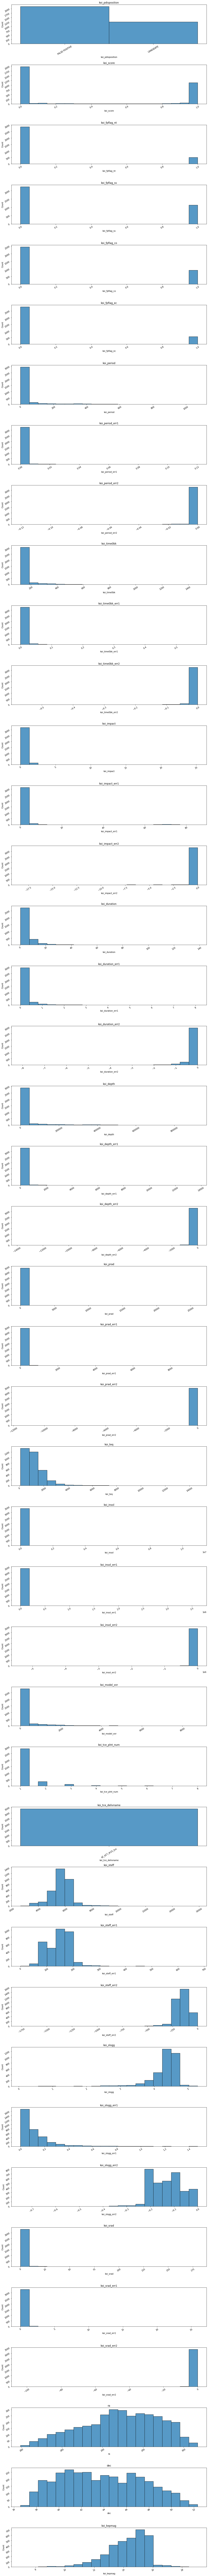

In [10]:
get_hist(train, train.drop(columns = 'disposition').columns)

##### Takeaway

There are a few features that possibly leak information about the target. These will be dropped, but we will verify the relationship first in the next section. A lot of features were the error of another feature. These likely won't be useful to us so they'll be dropped, perhaps at a later time these features can be analyzed. A few other features contain data that won't be very useful to us. These will also be dropped.

There were some features that had a lot of outliers that made seeing the distribution difficult. We'll take a look at those next.

#### Removing Outliers

Let's remove outliers from the following features and see the distributions again:
- koi_period
- koi_depth
- koi_prad
- koi_model_snr
- koi_srad

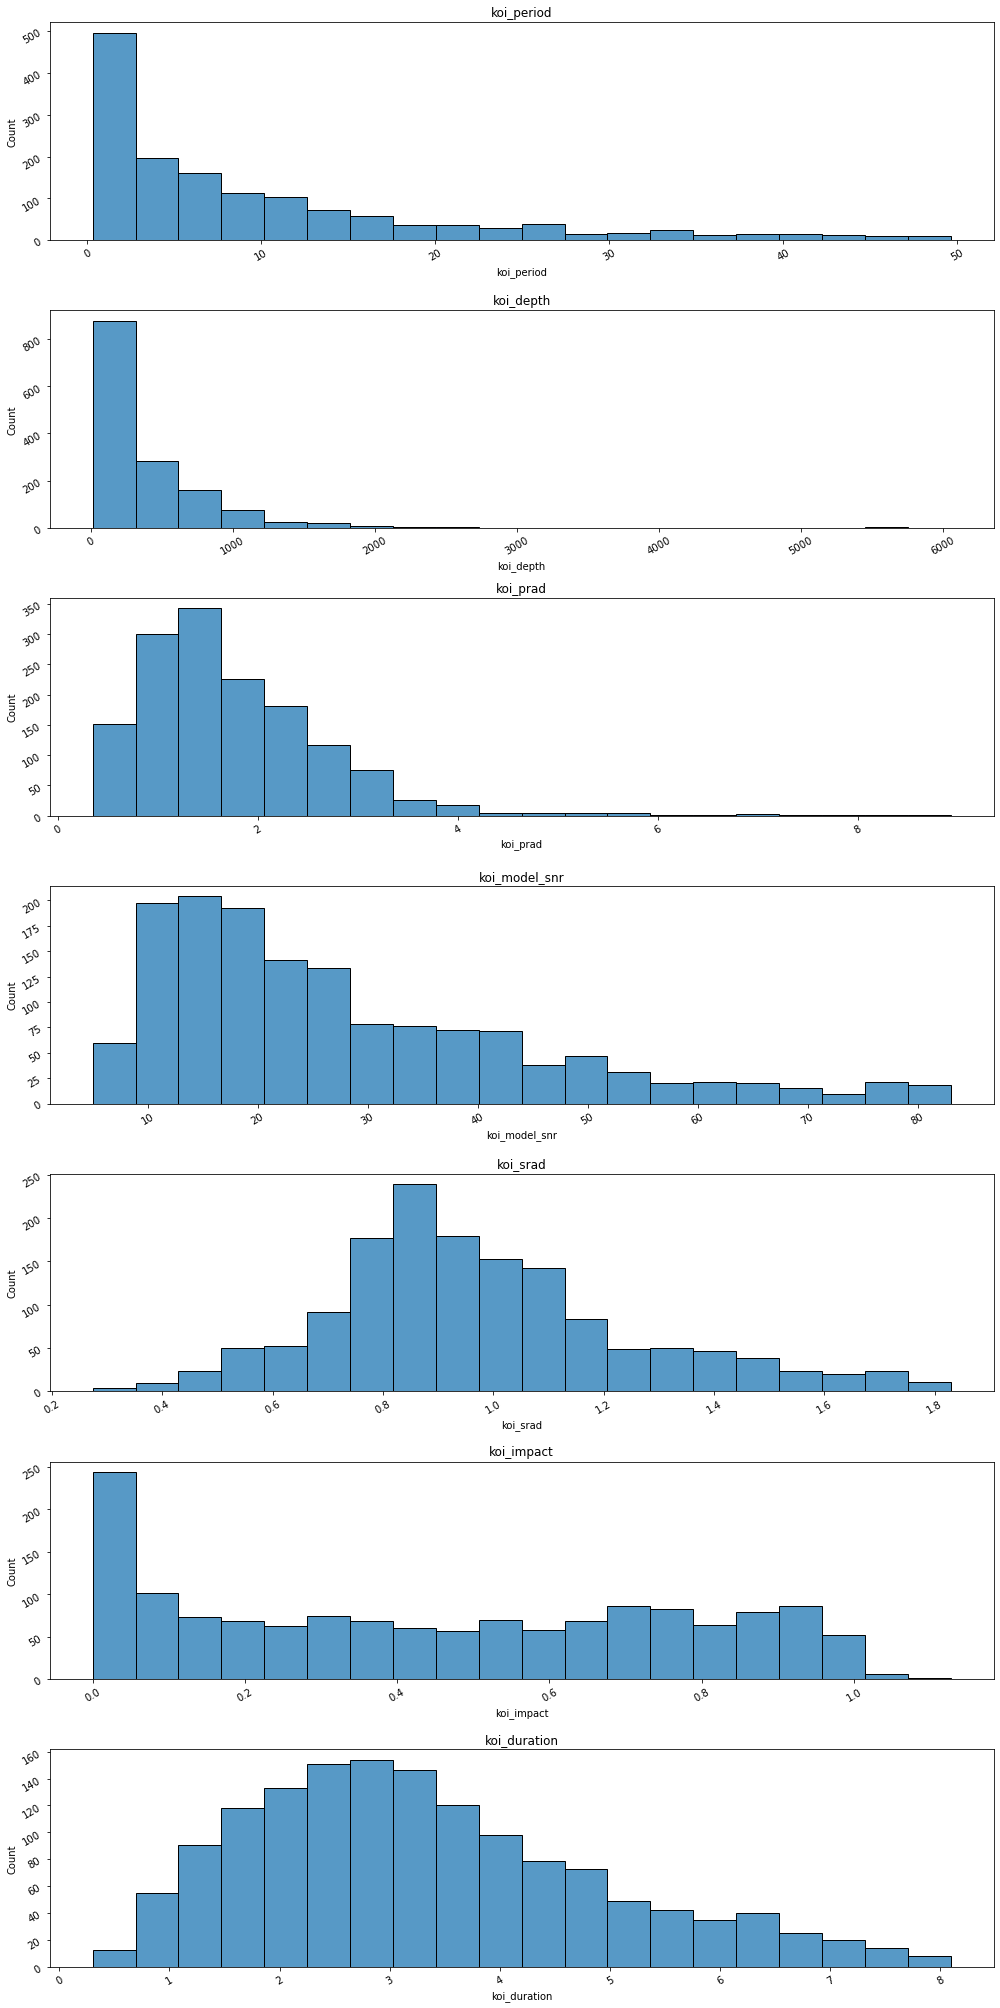

In [17]:
outlier_columns = [
    'koi_period',
    'koi_depth',
    'koi_prad',
    'koi_model_snr',
    'koi_srad',
    'koi_impact',
    'koi_duration'
]

get_hist(remove_outliers(train, 1.5, outlier_columns), outlier_columns)

In [18]:
remove_outliers(train, 1.5, columns).shape

(1537, 44)

##### Takeaway

Most of these features are right tailed. koi_srad has a roughly normal distribution. However, removing outliers does remove more than half of the observations. If one of these features proves to be useful for modeling we'll determine how to handle removing outliers in modeling.

#### Univariate Analysis Takeaways

Many features were discovered to not be very useful for the problem at hand. Some such as koi_pdisposition and koi_score possibly leak information about the target (though we'll confirm this shortly) and as such should not be used in modeling. Other features, such as those ending in err1 or err2, will not be used at this time due to time constraints. Although, I suspect these features might not be useful to us anyways, that is something to look into in a future pass through the pipeline. Some features like ra, dec, and koi_kepmag don't have much information in the data dictionary about what they are, but to the best of my knowledge are not directly related to the objects observed and as such will not be useful to us. There were also features like koi_tce_plnt_num, which is the planet number assigned to an exoplanet within its star system, and koi_tce_delivname, which only had 1 unique value, which will not be useful for other reasons. The following columns will be added to the drop list:

- koi_pdisposition
- koi_score
- koi_period_err1
- koi_period_err2
- koi_time0bk_err1
- koi_time0bk_err2
- koi_impact_err1
- koi_impact_err2
- koi_duration_err1
- koi_duration_err2
- koi_depth_err1
- koi_depth_err2
- koi_prad_err1
- koi_prad_err2
- koi_insol
- koi_insol_err1
- koi_insol_err2
- koi_tce_plnt_num
- koi_tce_delivname
- koi_steff_err1
- koi_steff_err2
- koi_slogg_err1
- koi_slogg_err2
- koi_srad_err1
- koi_srad_err2
- ra
- dec
- koi_kepmag

### Bivariate Analysis

Now let's see how each feature that we'll keep interacts with the target.

#### Verifying koi_pdisposition and koi_score Leak Information

Before we continue let's just verify that koi_pdisposition and koi_score leak information as I thought.

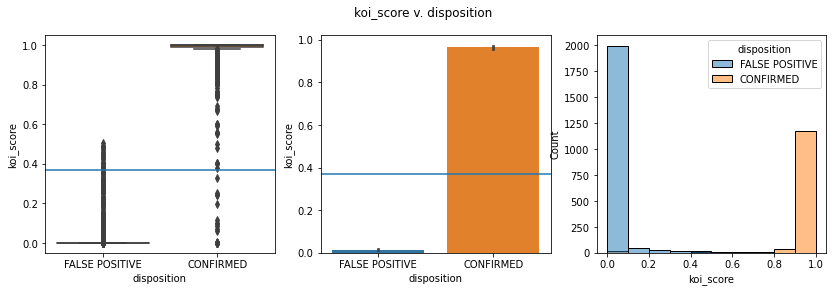

In [13]:
plot_categorical_and_continuous(train, ['disposition'], ['koi_score'])

There does seem to be a very strong relationship between disposition and koi_score. The koi_score is defined as the confidence in the disposition so it seems that this feature does in fact leak information.

In [14]:
train.disposition.value_counts(), train.koi_pdisposition.value_counts()

(FALSE POSITIVE    2107
 CONFIRMED         1269
 Name: disposition, dtype: int64,
 FALSE POSITIVE    2128
 CANDIDATE         1248
 Name: koi_pdisposition, dtype: int64)

The distribution of values here is very similar. So it seems that koi_pdisposition does leak information.

##### Takeaway

It does appear that these two features leak information about the target we won't use them in further exploration or modeling.

#### Set the Columns to Keep

In [15]:
columns_to_keep = [
    'koi_fpflag_nt',
    'koi_fpflag_ss',
    'koi_fpflag_co',
    'koi_fpflag_ec',
    'koi_period',
    'koi_time0bk',
    'koi_impact',
    'koi_duration',
    'koi_depth',
    'koi_prad',
    'koi_teq',
    'koi_model_snr',
    'koi_steff',
    'koi_slogg',
    'koi_srad'
]
len(columns_to_keep)

15

#### Plot Variables vs. Target

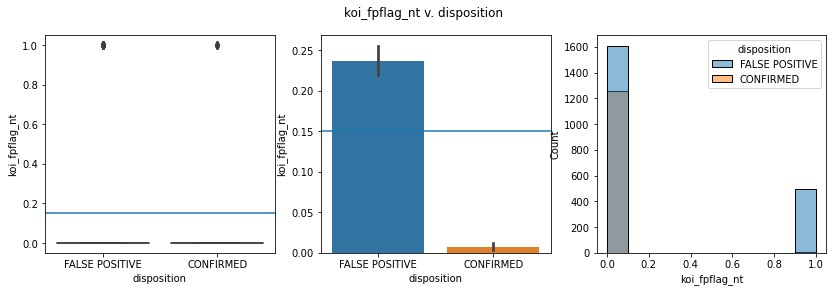

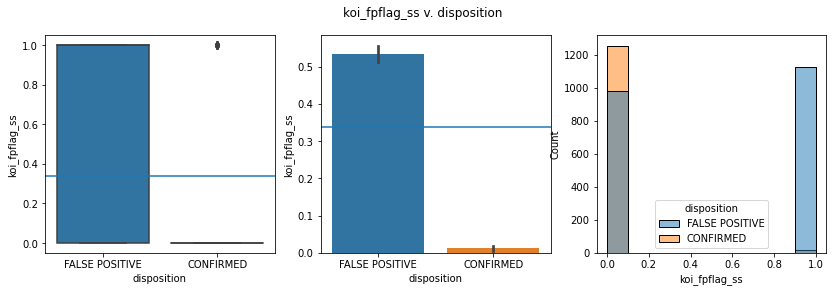

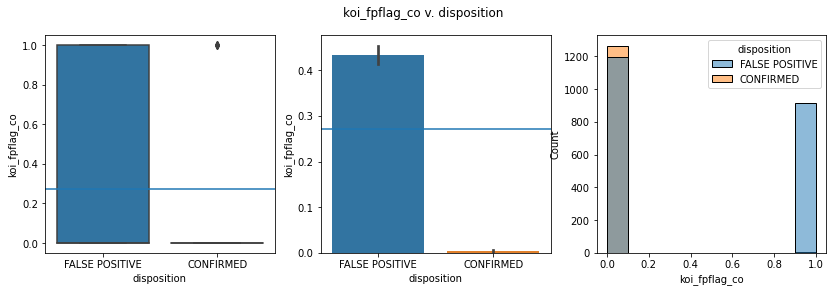

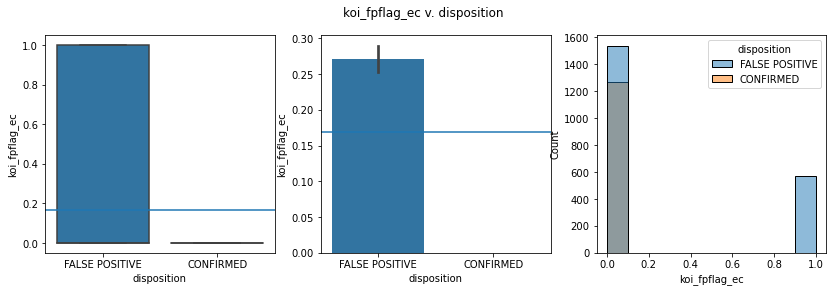

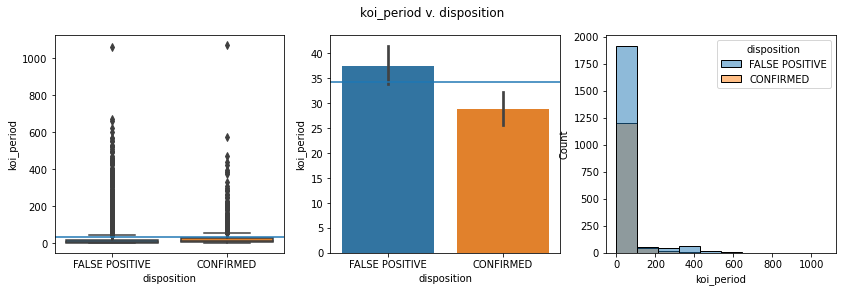

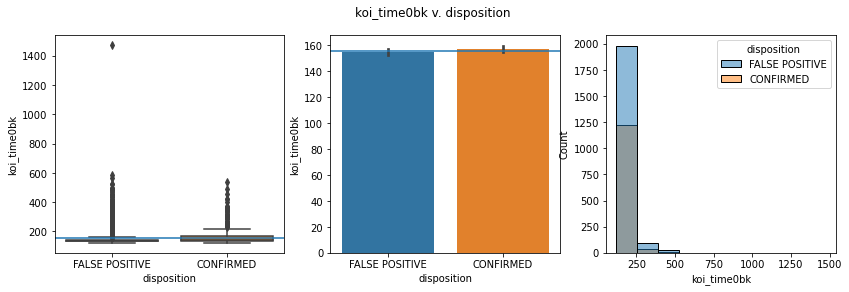

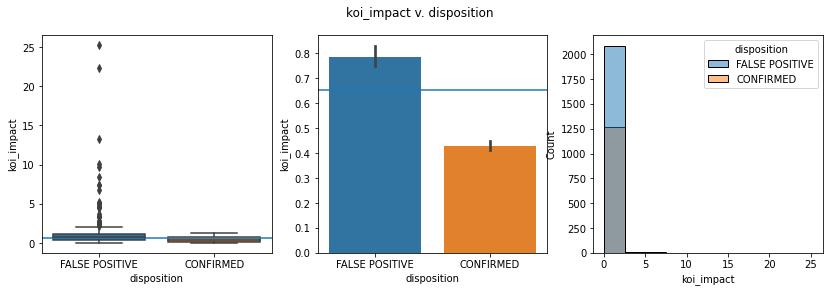

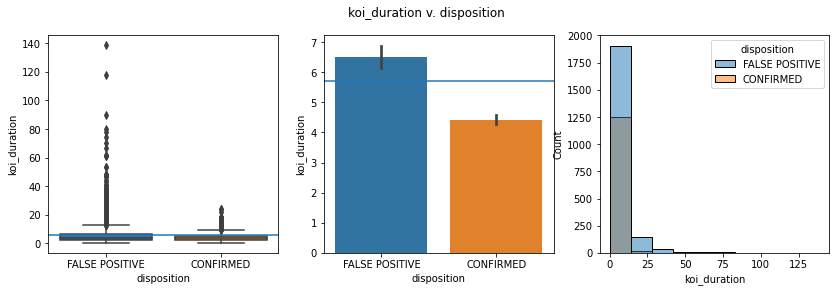

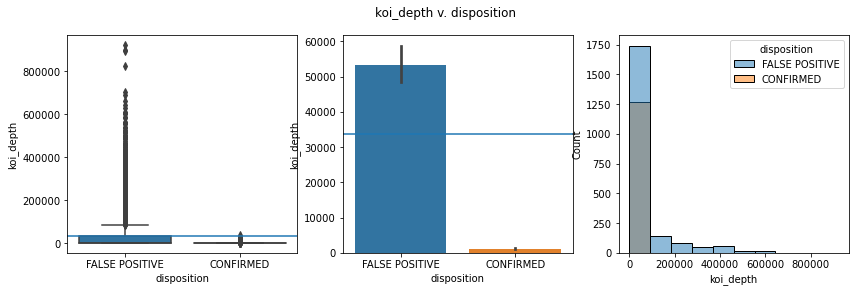

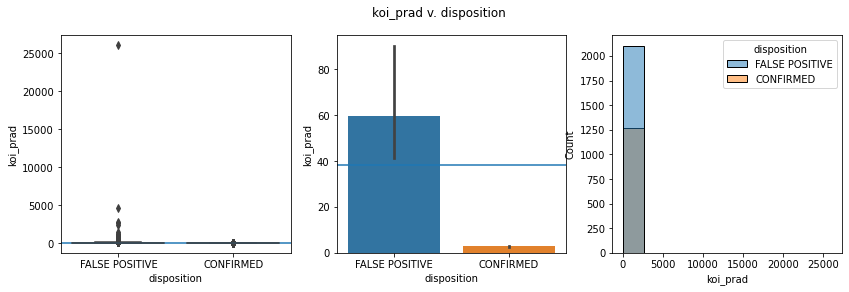

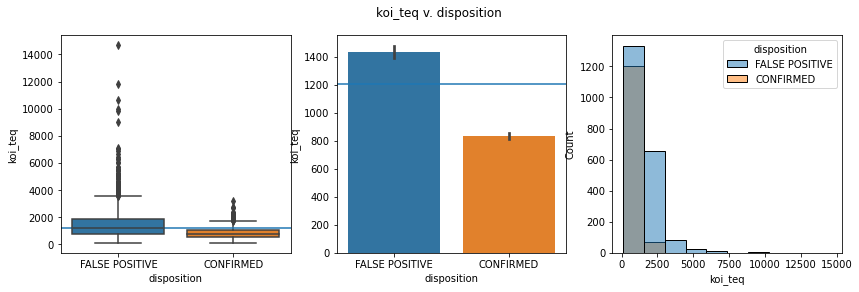

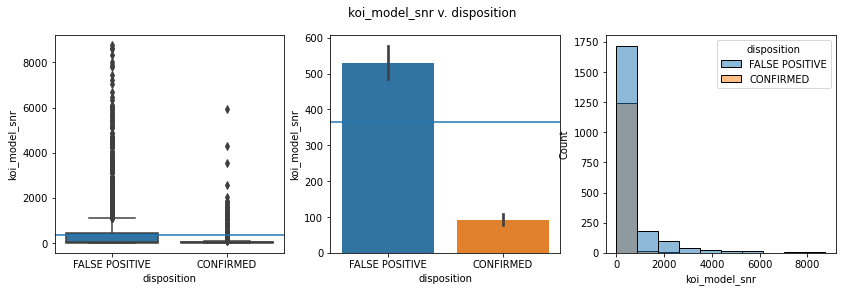

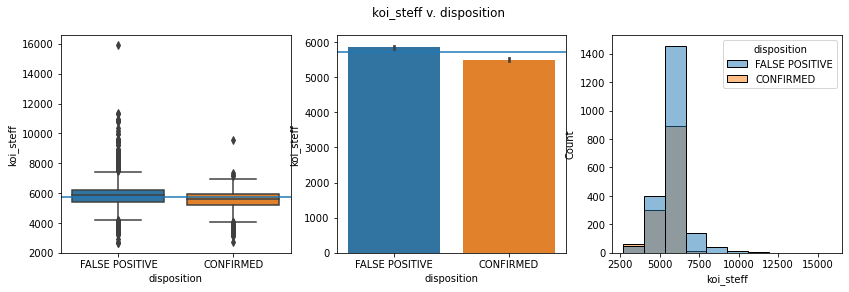

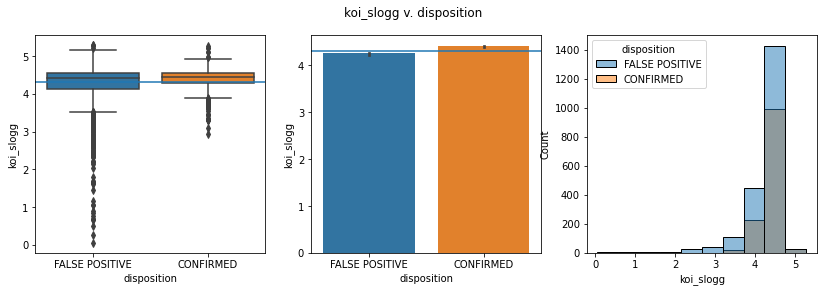

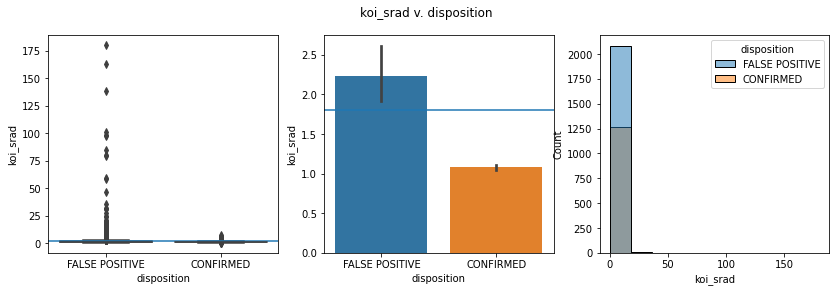

In [16]:
plot_categorical_and_continuous(train, ['disposition'], columns_to_keep)

##### Takeaway

There do seem to be some promising features that are predictive of false positives, however, there are some caveats. The features koi_fpflag_nt, koi_fpflag_ss, koi_fpflag_co, and koi_fpflag_ec are all highly predictive of false positives and alone could be used to produce a highly accurate model. However, I wonder if these features are leaking information. These features are defined as flags of an object potentially not being an exoplanet. Therefore, it is expected that these could be highly predictive of a false positive. I'm interested to know if any of the missing values were these flags and possibly observations with either candidate or not dispositioned disposition. We'll look into that next.

Aside from that the features koi_depth, koi_prad, koi_teq, and koi_model_snr are also all promising. Each of these features demonstrates that false positives tend to have higher values on average than confirmed exoplanets. Before we continue let's look again at some of our features that have a lot of outliers.

#### Removing Outliers

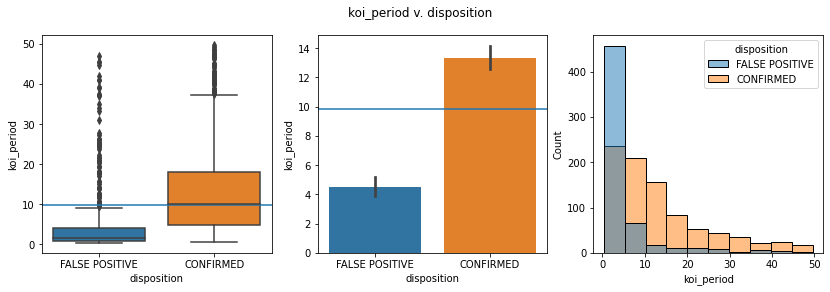

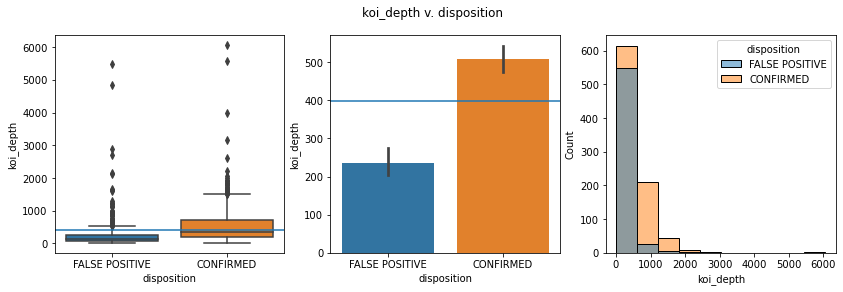

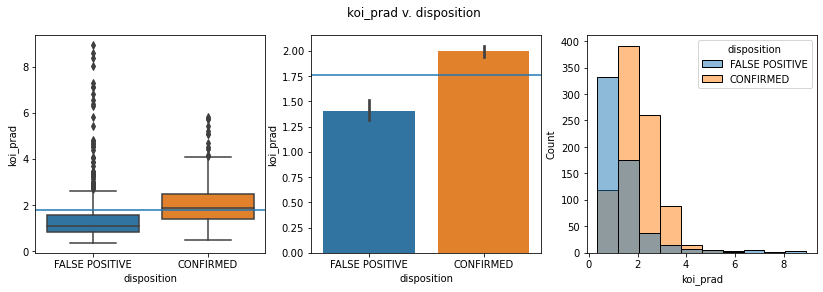

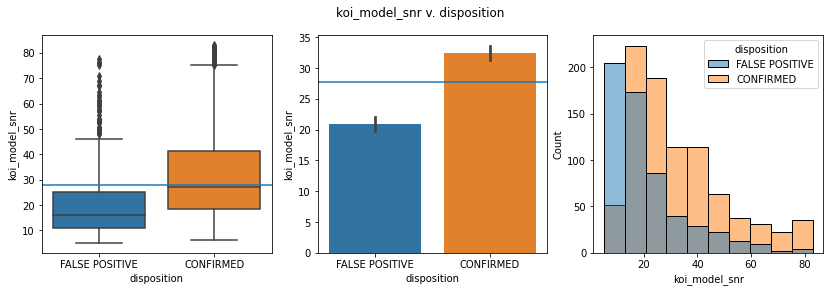

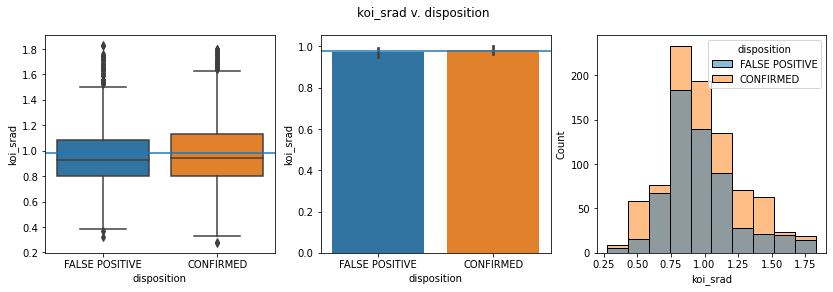

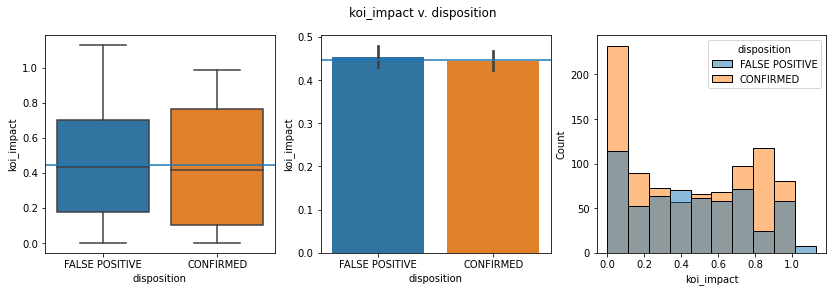

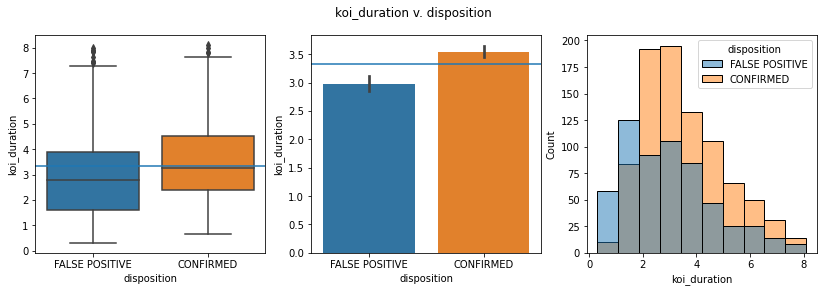

In [21]:
plot_categorical_and_continuous(remove_outliers(train, 1.5, outlier_columns), ['disposition'], outlier_columns)

##### Takeaway

In addition to the features already mentioned, koi_period and koi_duration look promising for predicting confirmed exoplanets when outliers are removed, but we'll test the significance of that soon.

#### Analyzing Flag Features

Let's analyze the features koi_fpflag_nt, koi_fpflag_ss, koi_fpflag_co, and koi_fpflag_ec to determine if we should proceed without these features. We'll look at the raw data to see how many observations have these features missing that are not dispositioned as false positive or confirmed.

In [27]:
# Get the raw data
kepler_raw = acquire.get_data()
kepler_raw.shape

(9564, 50)

In [29]:
# Let's look only at observations that are not CONFIRMED or FALSE POSITIVE
mask = (kepler_raw.koi_disposition == 'CANDIDATE') | (kepler_raw.koi_disposition == 'NOT DISPOSITIONED')
candidates = kepler_raw[mask]
candidates.shape

(2248, 50)

In [31]:
# Let's see the nulls
summarize_column_nulls(candidates)

,rows_missing,percent_missing
rowid,0,0.000000
kepid,0,0.000000
kepoi_name,0,0.000000
kepler_name,2248,1.000000
koi_disposition,0,0.000000
koi_pdisposition,0,0.000000
koi_score,451,0.200623
koi_fpflag_nt,0,0.000000
koi_fpflag_ss,0,0.000000
koi_fpflag_co,0,0.000000


The false positive flag features are all present. Let's see the nulls for the raw data.

In [32]:
summarize_column_nulls(kepler_raw)

,rows_missing,percent_missing
rowid,0,0.000000
kepid,0,0.000000
kepoi_name,0,0.000000
kepler_name,7270,0.760142
koi_disposition,0,0.000000
koi_pdisposition,0,0.000000
koi_score,1510,0.157884
koi_fpflag_nt,0,0.000000
koi_fpflag_ss,0,0.000000
koi_fpflag_co,0,0.000000


In [45]:
# Okay, but now let's see how many candidate exoplanets have one of these flags with a value of 1.
candidates[['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']].value_counts()

koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec
0              0              0              0                2216
               1              0              0                  32
dtype: int64

##### Takeaway

Those features are not missing at all in the raw data either. The data dictionary does not say anything about how these values are determined. However, from the value counts we can see that only a small number of candidate observations have one of these flags set to 1. This would indicate to me that they are not missing from the data because the default value is 0, but it only gets set to 1 after further analysis. It's possible that these features are used in the process of determining the disposition of an observation and as such do leak information about the target because in the case that an observation is given one of these flags it has already been identified as potentially a false positive. We won't use these any further.

#### Questions

Now let's ask some more pointed questions about the data. We'll focus only on the features we identified as potentially useful to the problem.

##### Do observations with a false positive disposition have higher values of koi_depth than confirmed exoplanets?

In [50]:
false_positives = train.disposition == 'FALSE POSITIVE'
confirmed = train.disposition == 'CONFIRMED'

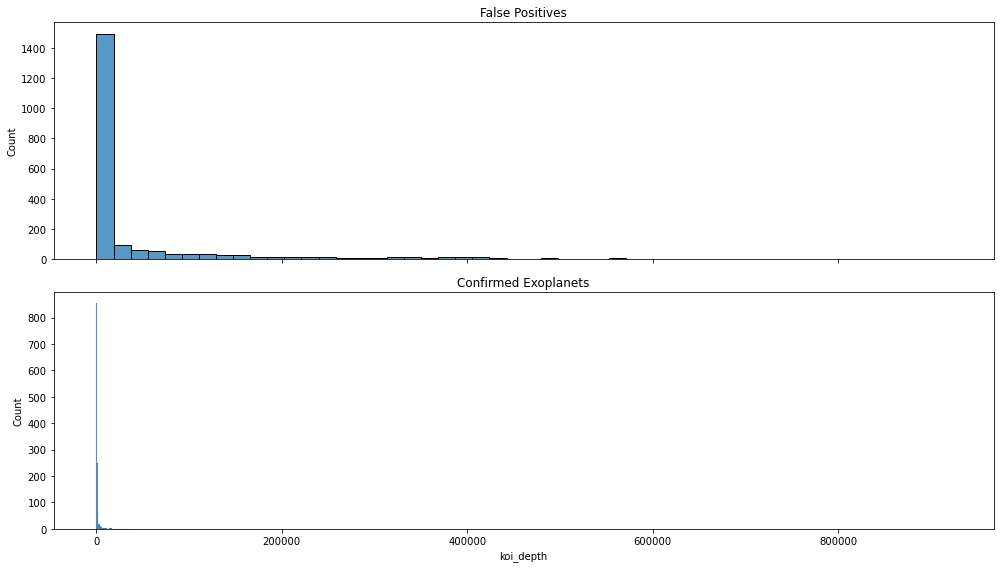

In [55]:
fig, ax = plt.subplots(ncols = 1, nrows = 2, sharex = True, figsize = (14, 8))
bins = 50

sns.histplot(data = train[false_positives], x = 'koi_depth', bins = bins, ax = ax[0])
ax[0].set_title('False Positives')

sns.histplot(data = train[confirmed], x = 'koi_depth', bins = bins, ax = ax[1])
ax[1].set_title('Confirmed Exoplanets')

plt.tight_layout();

It definitely looks like false positives have larger koi_depth values. Let's run a stats test to verify.

In [56]:
# We'll perform a two sample t-test. Let's start by testing for equal variance.

# H0: The variance of koi_depth between false positives and confirmed exoplanets is equal.
alpha = 0.05

_, p = stats.levene(train[false_positives].koi_depth, train[confirmed].koi_depth)

if p < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

Reject H0


In [57]:
# H0: The average koi_depth for false positives is equal to the average koi_depth for confirmed exoplanets.
# Ha: The average koi_depth for false positives is significantly greater than the average koi_depth for confirmed exoplanets.

_, p = stats.ttest_ind(train[false_positives].koi_depth, train[confirmed].koi_depth, equal_var = False, alternative = 'greater')

if p < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

Reject H0


So the results are that the average koi_depth for false positives is significantly greater than the average koi_depth for confirmed exoplanets.

##### Do observations with a false positive disposition have higher values of koi_prad than confirmed exoplanets?

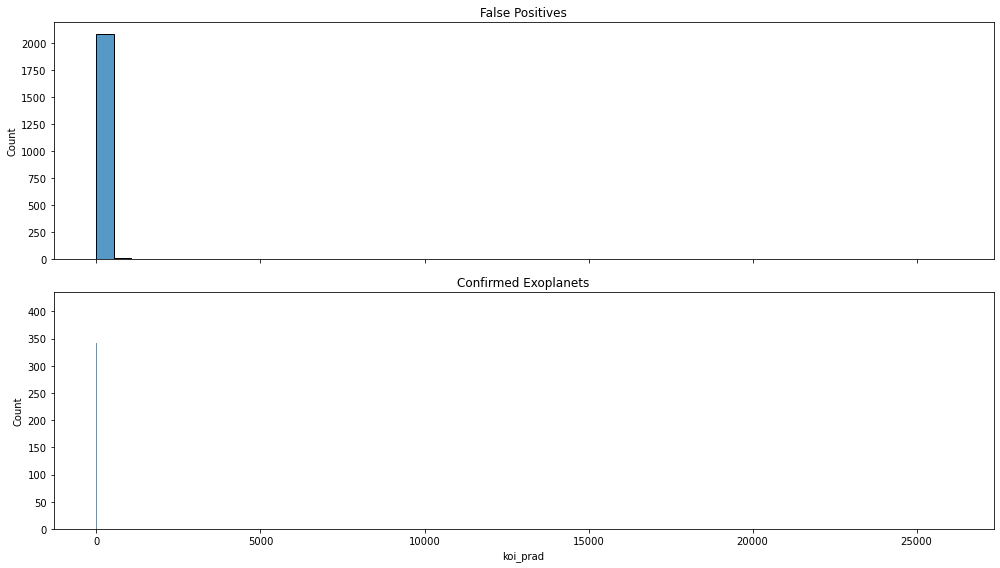

In [58]:
fig, ax = plt.subplots(ncols = 1, nrows = 2, sharex = True, figsize = (14, 8))
bins = 50

sns.histplot(data = train[false_positives], x = 'koi_prad', bins = bins, ax = ax[0])
ax[0].set_title('False Positives')

sns.histplot(data = train[confirmed], x = 'koi_prad', bins = bins, ax = ax[1])
ax[1].set_title('Confirmed Exoplanets')

plt.tight_layout();

It looks like the average value of koi_prad is significantly higher for false positives. Let's run a stats test to verify.

In [59]:
# We'll perform a two sample t-test. Let's start by testing for equal variance.

# H0: The variance of koi_prad between false positives and confirmed exoplanets is equal.
alpha = 0.05

_, p = stats.levene(train[false_positives].koi_prad, train[confirmed].koi_prad)

if p < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

Reject H0


In [60]:
# H0: The average koi_prad for false positives is equal to the average koi_prad for confirmed exoplanets.
# Ha: The average koi_prad for false positives is significantly greater than the average koi_prad for confirmed exoplanets.

_, p = stats.ttest_ind(train[false_positives].koi_prad, train[confirmed].koi_prad, equal_var = False, alternative = 'greater')

if p < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

Reject H0


So the results are that the average koi_prad for false positives is significantly greater than the average koi_prad for confirmed exoplanets.

##### Do observations with a false positive disposition have significantly different values of koi_teq than confirmed exoplanets?

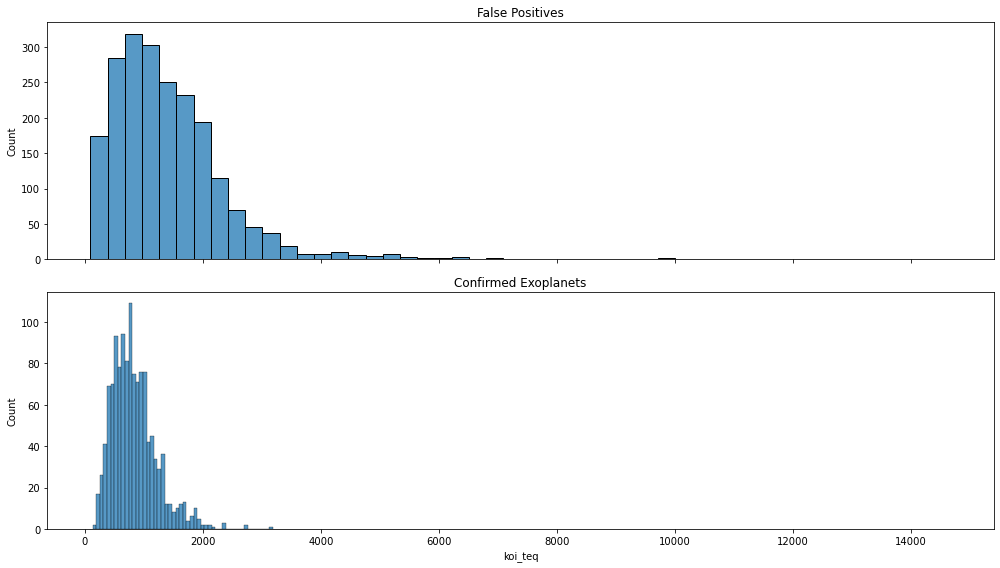

In [61]:
fig, ax = plt.subplots(ncols = 1, nrows = 2, sharex = True, figsize = (14, 8))
bins = 50

sns.histplot(data = train[false_positives], x = 'koi_teq', bins = bins, ax = ax[0])
ax[0].set_title('False Positives')

sns.histplot(data = train[confirmed], x = 'koi_teq', bins = bins, ax = ax[1])
ax[1].set_title('Confirmed Exoplanets')

plt.tight_layout();

There does seem to be a significant difference in the range of values for each disposition. Let's run a stats test to determine if there is significance in the difference.

In [62]:
# We'll perform a two sample t-test. Let's start by testing for equal variance.

# H0: The variance of koi_teq between false positives and confirmed exoplanets is equal.
alpha = 0.05

_, p = stats.levene(train[false_positives].koi_teq, train[confirmed].koi_teq)

if p < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

Reject H0


In [70]:
# H0: The average koi_teq for false positives is equal to the average koi_teq for confirmed exoplanets.
# Ha: The average koi_teq for false positives is not equal to the average koi_teq for confirmed exoplanets.

_, p = stats.ttest_ind(train[false_positives].koi_teq, train[confirmed].koi_teq, equal_var = False)

if p < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

Reject H0


So the results here are that there is a significant difference in koi_teq between false positives and confirmed exoplanets.

##### Do observations with a false positive disposition have higher values of koi_model_snr than confirmed exoplanets?

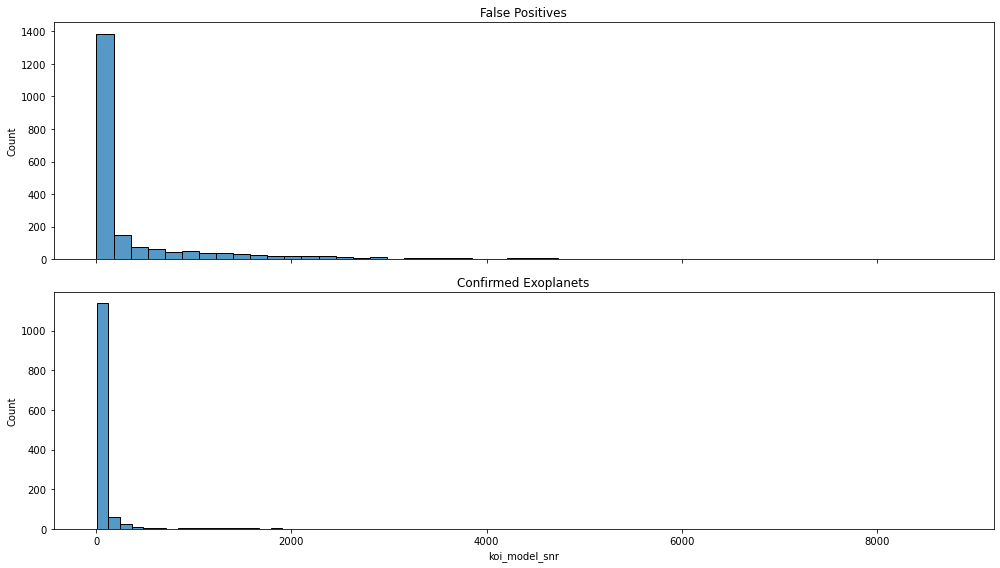

In [64]:
fig, ax = plt.subplots(ncols = 1, nrows = 2, sharex = True, figsize = (14, 8))
bins = 50

sns.histplot(data = train[false_positives], x = 'koi_model_snr', bins = bins, ax = ax[0])
ax[0].set_title('False Positives')

sns.histplot(data = train[confirmed], x = 'koi_model_snr', bins = bins, ax = ax[1])
ax[1].set_title('Confirmed Exoplanets')

plt.tight_layout();

There may be a significant difference here, but its hard to tell. Let's run a stats test to determine this.

In [65]:
# We'll perform a two sample t-test. Let's start by testing for equal variance.

# H0: The variance of koi_model_snr between false positives and confirmed exoplanets is equal.
alpha = 0.05

_, p = stats.levene(train[false_positives].koi_model_snr, train[confirmed].koi_model_snr)

if p < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

Reject H0


In [67]:
# H0: The average koi_model_snr for false positives is equal to the average koi_model_snr for confirmed exoplanets.
# Ha: The average koi_model_snr for false positives is significantly greater than the average koi_model_snr
# for confirmed exoplanets.

_, p = stats.ttest_ind(train[false_positives].koi_model_snr, train[confirmed].koi_model_snr, equal_var = False, alternative = 'greater')

if p < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

Reject H0


So the results are that the average koi_model_snr for false positives is significantly greater than the average koi_model_snr for confirmed exoplanets.

##### Is there a significant difference in koi_period between false positives and confirmed exoplanets?

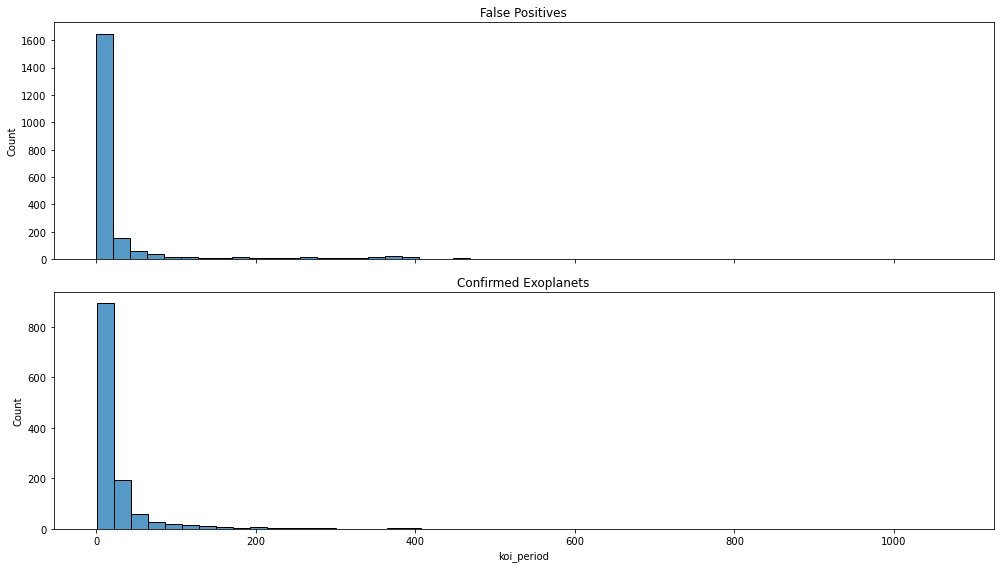

In [68]:
fig, ax = plt.subplots(ncols = 1, nrows = 2, sharex = True, figsize = (14, 8))
bins = 50

sns.histplot(data = train[false_positives], x = 'koi_period', bins = bins, ax = ax[0])
ax[0].set_title('False Positives')

sns.histplot(data = train[confirmed], x = 'koi_period', bins = bins, ax = ax[1])
ax[1].set_title('Confirmed Exoplanets')

plt.tight_layout();

There may not be any significant difference here. Let's run a stats test to verify.

In [69]:
# We'll perform a two sample t-test. Let's start by testing for equal variance.

# H0: The variance of koi_period between false positives and confirmed exoplanets is equal.
alpha = 0.05

_, p = stats.levene(train[false_positives].koi_period, train[confirmed].koi_period)

if p < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

Reject H0


In [71]:
# H0: The average koi_period for false positives is equal to the average koi_period for confirmed exoplanets.
# Ha: The average koi_period for false positives is not equal to the average koi_period for confirmed exoplanets.

_, p = stats.ttest_ind(train[false_positives].koi_period, train[confirmed].koi_period, equal_var = False)

if p < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

Reject H0


The results show that there is a significant difference in koi_period between false positives and confirmed exoplanets.

##### Is there a significant difference in koi_duration between false positives and confirmed exoplanets?

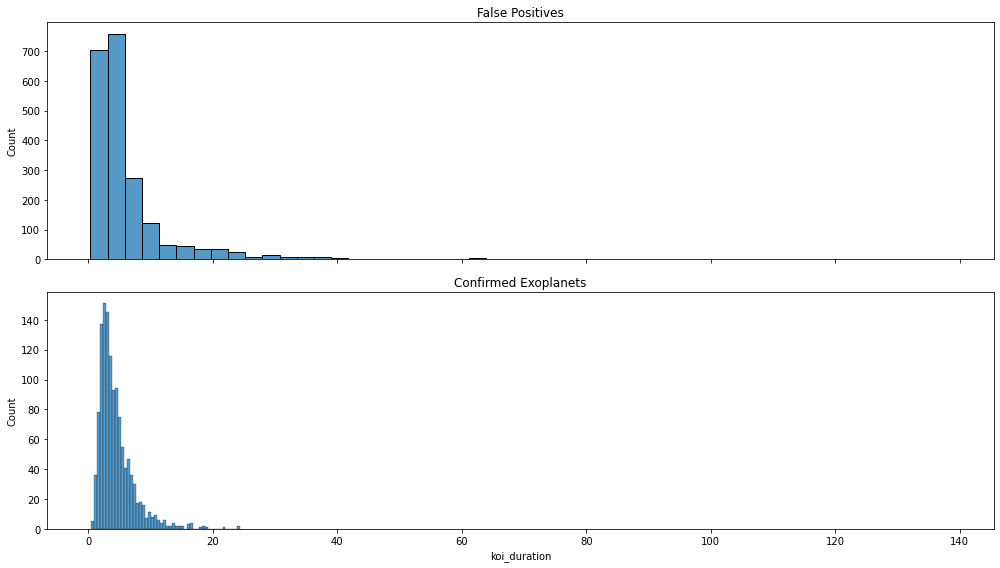

In [72]:
fig, ax = plt.subplots(ncols = 1, nrows = 2, sharex = True, figsize = (14, 8))
bins = 50

sns.histplot(data = train[false_positives], x = 'koi_duration', bins = bins, ax = ax[0])
ax[0].set_title('False Positives')

sns.histplot(data = train[confirmed], x = 'koi_duration', bins = bins, ax = ax[1])
ax[1].set_title('Confirmed Exoplanets')

plt.tight_layout();

It looks like there is a significant difference here. Let's run a stats test to verify.

In [73]:
# We'll perform a two sample t-test. Let's start by testing for equal variance.

# H0: The variance of koi_duration between false positives and confirmed exoplanets is equal.
alpha = 0.05

_, p = stats.levene(train[false_positives].koi_duration, train[confirmed].koi_duration)

if p < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

Reject H0


In [74]:
# H0: The average koi_duration for false positives is equal to the average koi_duration for confirmed exoplanets.
# Ha: The average koi_duration for false positives is not equal to the average koi_duration for confirmed exoplanets.

_, p = stats.ttest_ind(train[false_positives].koi_duration, train[confirmed].koi_duration, equal_var = False)

if p < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

Reject H0


The results are that there is a significant difference in koi_duration between false positives and confirmed exoplanets.

##### Takeaways

All of the features we identified before show promise in being significant for determining the disposition of an exoplanet. We'll be moving forward with these in modeling.

### Multivariate Analysis

Now let's see how the features we have selected interact with each other to see if we can potentially engineer any features or use a clustering model.

#### Pairplot

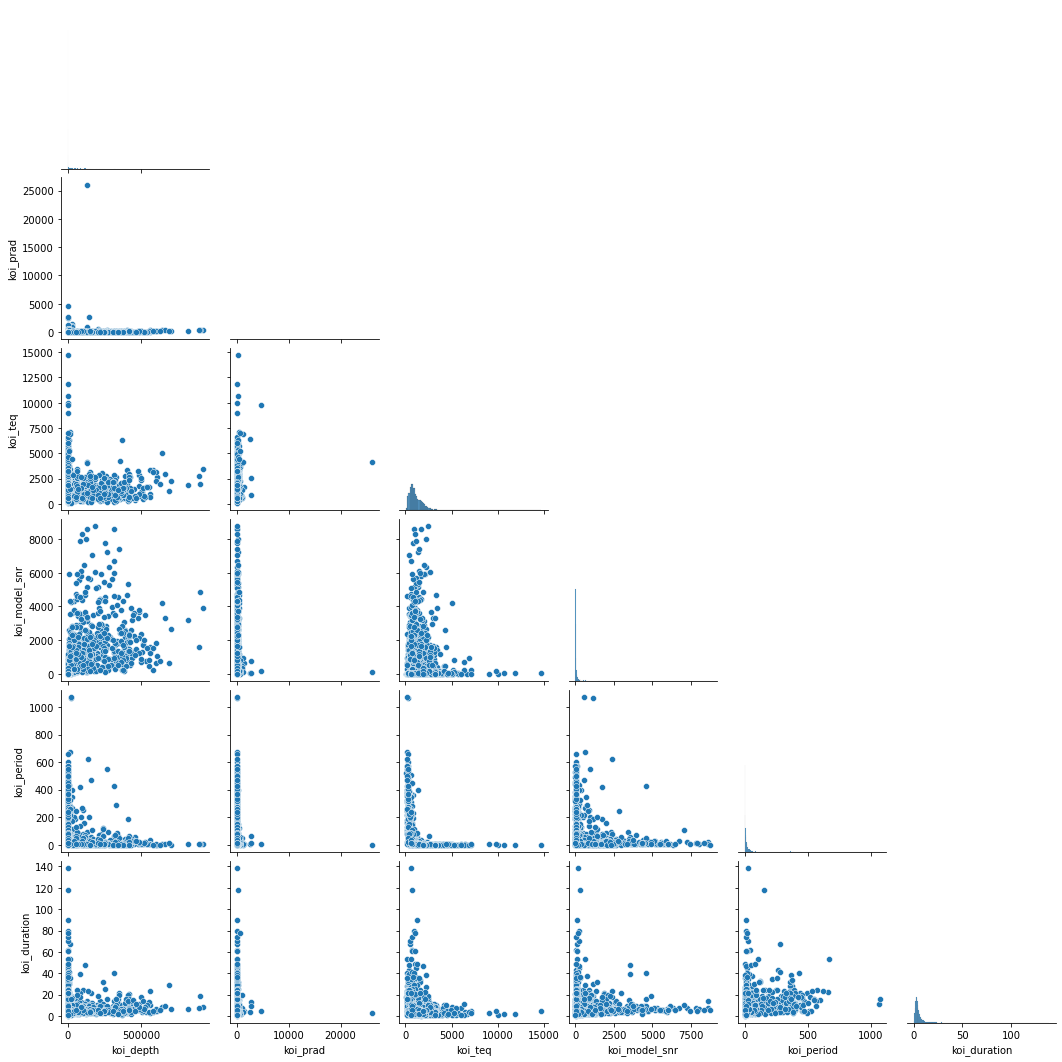

In [76]:
columns_to_keep = [
    'koi_depth',
    'koi_prad',
    'koi_teq',
    'koi_model_snr',
    'koi_period',
    'koi_duration'
]

sns.pairplot(data = train[columns_to_keep], corner = True);

There may be some groups between koi_period, koi_duration, koi_teq, and koi_depth. Let's see a plot of these four features. Let's remove outliers first.

In [83]:
outliers_removed = remove_outliers(train, 3.0, columns_to_keep)

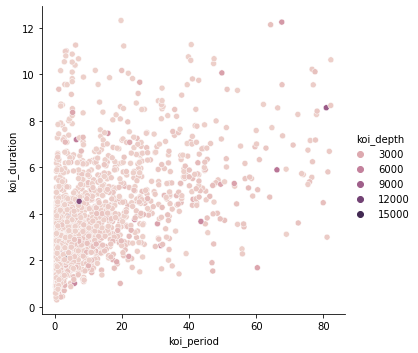

In [84]:
sns.relplot(data = outliers_removed, x = 'koi_period', y = 'koi_duration', hue = 'koi_depth');

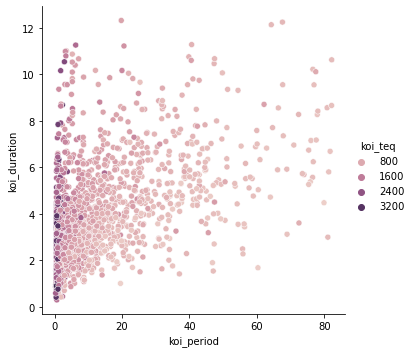

In [85]:
sns.relplot(data = outliers_removed, x = 'koi_period', y = 'koi_duration', hue = 'koi_teq');

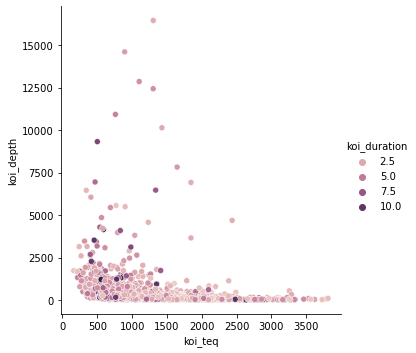

In [86]:
sns.relplot(data = outliers_removed, x = 'koi_teq', y = 'koi_depth', hue = 'koi_duration');

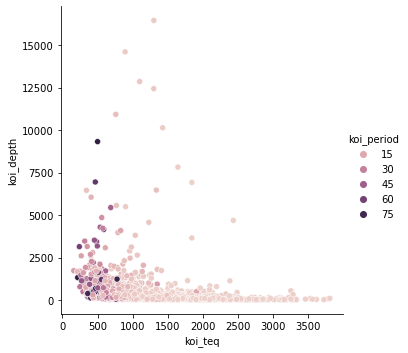

In [87]:
sns.relplot(data = outliers_removed, x = 'koi_teq', y = 'koi_depth', hue = 'koi_period');

##### Takeaway

**First Pass**
There might be some potential for clustering between koi_period, koi_duration, and koi_teq, but at this time we won't be doing any of that. We'll conclude with what we have found so far.

## Conclusion

Many features were identified as leaking information, such as koi_pdisposition, koi_score, koi_fpflag_nt, koi_fpflag_ss, koi_fpflag_co, and koi_fpflag_ec. These features will not be used in modeling because using them defeats the purpose of the project which is to identify attributes that can be predictive of a false positive or confirmed disposition without having additional information. 

Other features will not be used at this time because they were deemed to be likely unuseful. These were mostly the error features, which are the error in a particular measurement. While some these features could be useful, particularly those related to the features we are moving forward into modeling with, at this time we won't be using them. The error in a measurement is likely more closely related to the specific measurement than the target variable.

Some features, such as koi_impact, koi_srad, koi_slogg, koi_steff, and koi_time0bk did not show much promise when plotted against the target variable. These features showed even splits between false positives and confirmed exoplanets indicating that they are not very predictive of the disposition.

Finally, the features, koi_depth, koi_prad, koi_teq, koi_model_snr, koi_period, and koi_duration all showed promise when plotted against the target variable. There were distinct differences in values between false positives and confirmed exoplanets. Additionally, all statistics tests executed confirmed that there were significant differences in values between the two groups for each feature. That being said we'll move forward into modeling with these features.

There is some potential for creating clusters as there do seem to be some existing groups in the data. However due to time constraints at this time that strategy will not be pursued.